# Enhanced Soil Fertility Analysis using K-Nearest Neighbors (KNN)

This notebook implements an enhanced KNN model for soil fertility analysis using:
1. Feature Engineering and Selection
2. Class Imbalance Handling
3. Ensemble Learning
4. Advanced Model Evaluation
5. Feature Importance Analysis

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
import joblib

np.random.seed(42)

## 1. Data Loading and Exploration

In [2]:
# Load dataset
df = pd.read_csv('../Datasets/dataset_1.csv')
print('Dataset Info:')
print(df.info())
print('\nFirst few rows:')
print(df.head())
print('\nSummary statistics:')
print(df.describe())
print('\nClass distribution:')
print(df['Output'].value_counts(normalize=True))

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880 entries, 0 to 879
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   N       880 non-null    int64  
 1   P       880 non-null    float64
 2   K       880 non-null    int64  
 3   EC      880 non-null    float64
 4   Fe      880 non-null    float64
 5   Output  880 non-null    int64  
dtypes: float64(3), int64(3)
memory usage: 41.4 KB
None

First few rows:
     N    P    K    EC    Fe  Output
0  138  8.6  560  0.62  0.31       0
1  213  7.5  338  0.75  0.86       0
2  163  9.6  718  0.51  0.86       0
3  157  6.8  475  0.58  0.54       0
4  270  9.9  444  0.40  0.76       1

Summary statistics:
               N           P           K          EC          Fe      Output
count  880.00000  880.000000  880.000000  880.000000  880.000000  880.000000
mean   246.73750   14.562159  499.978409    0.543659    4.140523    0.588636
std     77.38886   21.967755  124.22283

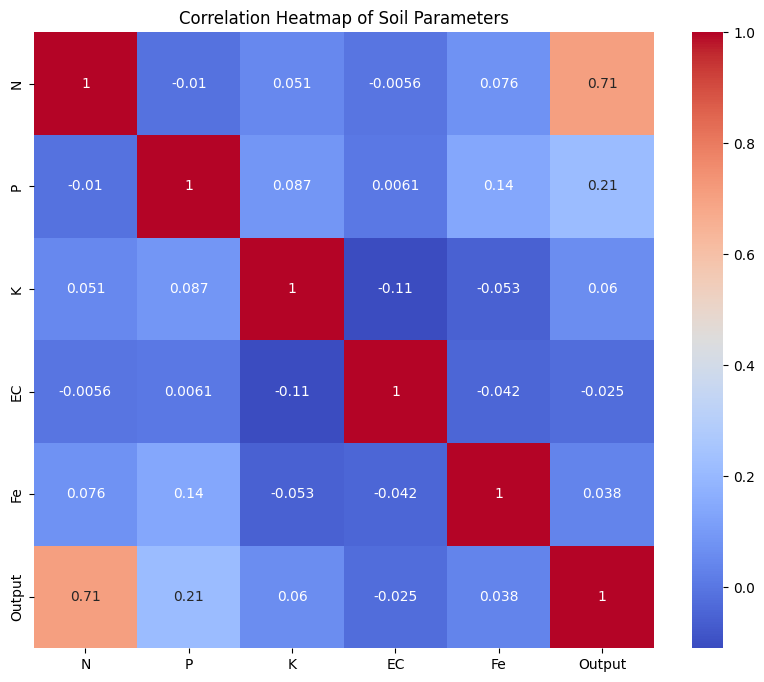

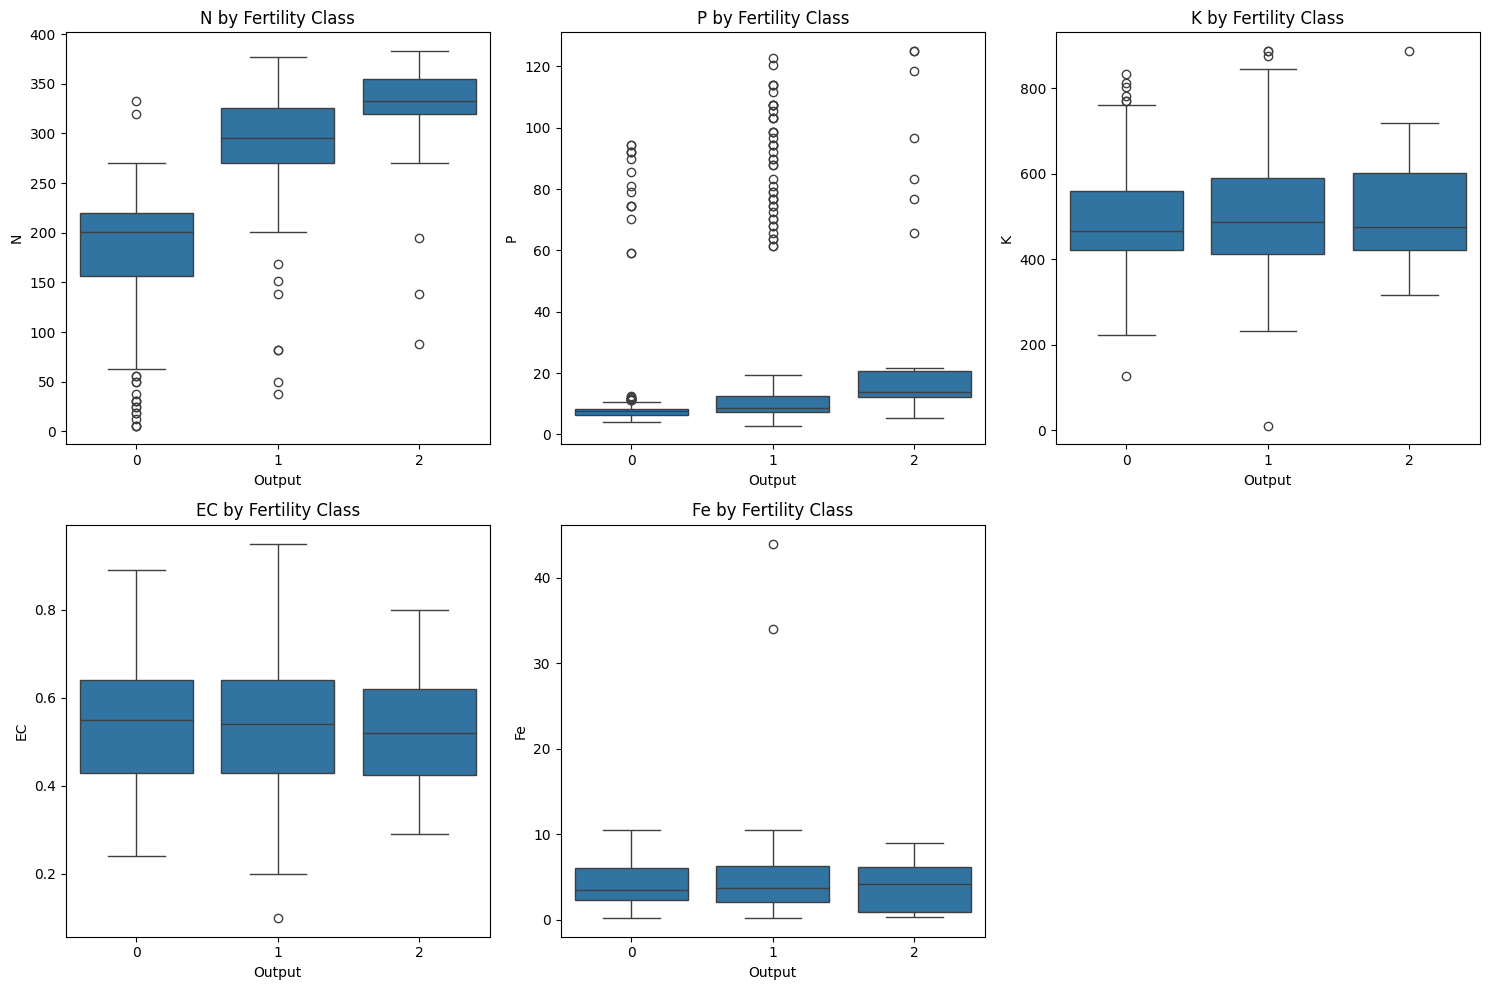

In [3]:
# Data visualization
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Soil Parameters')
plt.show()

features = ['N', 'P', 'K', 'EC', 'Fe']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Output', y=feature, data=df)
    plt.title(f'{feature} by Fertility Class')
plt.tight_layout()
plt.show()

## 2. Enhanced Model Pipeline Setup

In [4]:
# Prepare data
X = df.drop('Output', axis=1)
y = df['Output']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Create ensemble of KNN classifiers
estimators = [
    ('knn1', KNeighborsClassifier(n_neighbors=5, weights='distance', metric='minkowski', p=2)),
    ('knn2', KNeighborsClassifier(n_neighbors=7, weights='distance', metric='manhattan')),
    ('knn3', KNeighborsClassifier(n_neighbors=9, weights='uniform', metric='chebyshev'))
]

ensemble = VotingClassifier(estimators=estimators, voting='soft')

pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('selector', SelectKBest(score_func=f_classif, k=20)),
    ('smote', SMOTE(random_state=42)),
    ('ensemble', ensemble)
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('poly', PolynomialFeatures(include_bias=False)),
                ('selector', SelectKBest(k=20)),
                ('smote', SMOTE(random_state=42)),
                ('ensemble',
                 VotingClassifier(estimators=[('knn1',
                                               KNeighborsClassifier(weights='distance')),
                                              ('knn2',
                                               KNeighborsClassifier(metric='manhattan',
                                                                    n_neighbors=7,
                                                                    weights='distance')),
                                              ('knn3',
                                               KNeighborsClassifier(metric='chebyshev',
                                                                    n_neighbors=9))],
                                  voting='soft'))])

## 3. Model Evaluation

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.86        80
           1       0.78      0.70      0.74        88
           2       0.11      0.25      0.15         8

    accuracy                           0.75       176
   macro avg       0.59      0.60      0.58       176
weighted avg       0.79      0.75      0.77       176



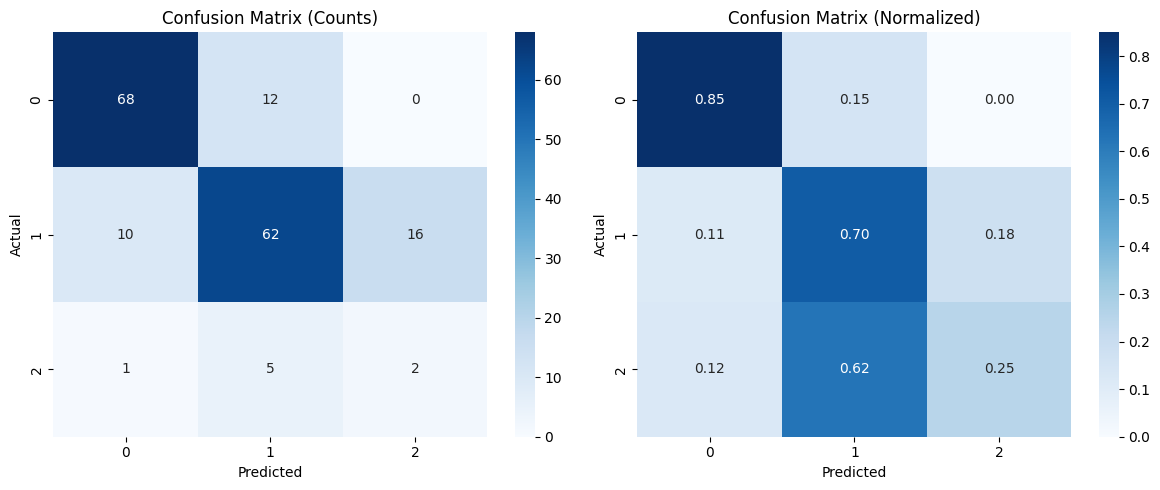

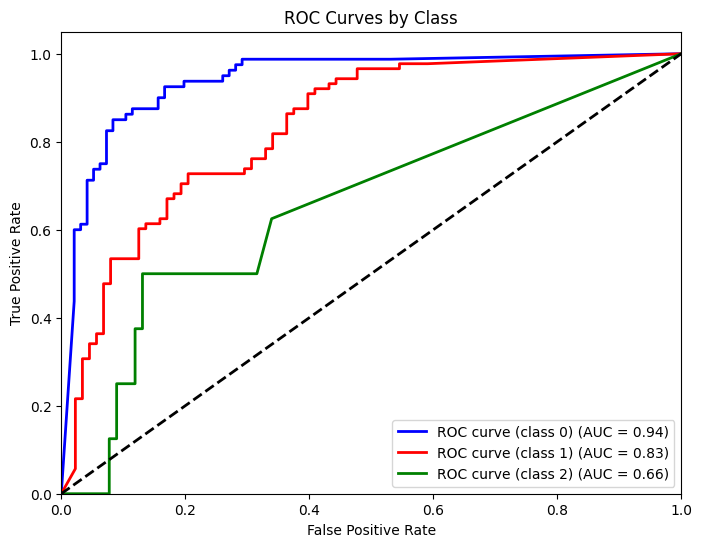

In [5]:
# Make predictions
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)

print('Classification Report:')
print(classification_report(y_test, y_pred))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Counts)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.subplot(1, 2, 2)
cm_norm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues')
plt.title('Confusion Matrix (Normalized)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# ROC curves
n_classes = len(np.unique(y))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure(figsize=(8, 6))
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve (class {i}) (AUC = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves by Class')
plt.legend(loc='lower right')
plt.show()

## 4. Feature Importance Analysis

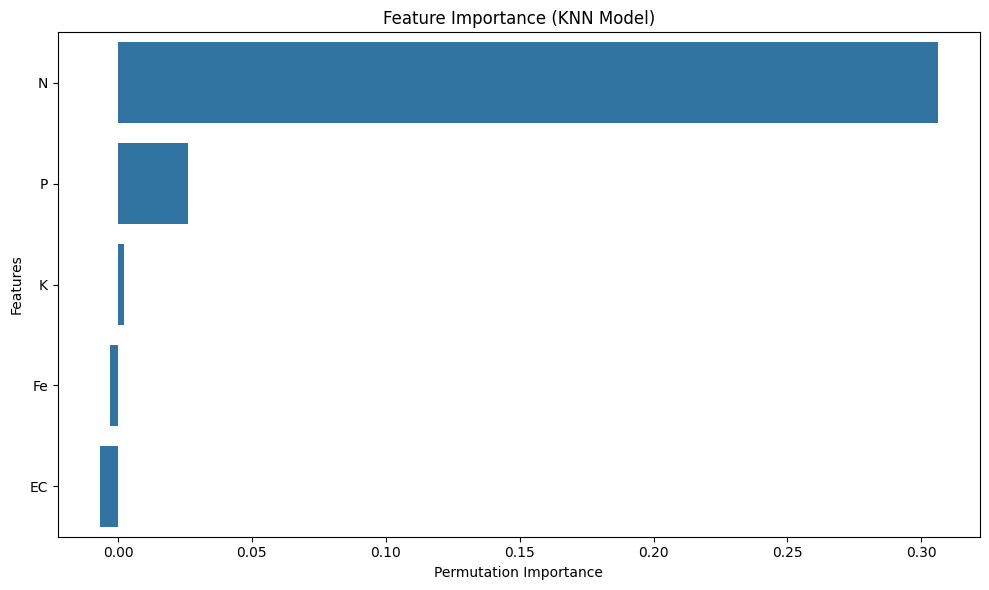


Feature Importance Ranking:
  feature  importance
0       N    0.306250
1       P    0.026136
2       K    0.002273
4      Fe   -0.002841
3      EC   -0.006818


In [6]:
# Permutation importance
result = permutation_importance(
    pipeline, X_test, y_test,
    n_repeats=10,
    random_state=42
)
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': result.importances_mean
}).sort_values('importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title('Feature Importance (KNN Model)')
plt.xlabel('Permutation Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()
print('\nFeature Importance Ranking:')
print(importance_df)

## 5. Model Export and Example Prediction

In [7]:
# Save the complete pipeline
joblib.dump(pipeline, '../Models/enhanced_soil_fertility_knn.joblib')
importance_df.to_csv('../Models/enhanced_knn_feature_importance.csv', index=False)
print('Model and feature importance saved successfully!')

# Example prediction
sample_input = pd.DataFrame({
    'N': [200],
    'P': [8.0],
    'K': [500],
    'EC': [0.5],
    'Fe': [0.6]
})
prediction = pipeline.predict(sample_input)
probabilities = pipeline.predict_proba(sample_input)
print('\nExample Prediction:')
print('Input Features:')
print(sample_input)
print(f'\nPredicted class: {prediction[0]}')
print('\nClass probabilities:')
for i, prob in enumerate(probabilities[0]):
    print(f'Class {i}: {prob:.4f}')

Model and feature importance saved successfully!

Example Prediction:
Input Features:
     N    P    K   EC   Fe
0  200  8.0  500  0.5  0.6

Predicted class: 0

Class probabilities:
Class 0: 0.8889
Class 1: 0.1111
Class 2: 0.0000
